In [18]:
!
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apachemirror.wuchna.com/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [30]:
!apt-get install adoptopenjdk8

E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?


In [19]:
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"

In [2]:
os.environ['SPARK_HOME'] = "spark-2.4.5-bin-hadoop2.7/"

In [3]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")

In [4]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS #, Rating #, MatrixFactorizationModel

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [6]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:

# set random seed for reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [8]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("movie-recommender-pyspark")
         .getOrCreate())
spark

In [9]:

sc = spark.sparkContext
sc
print (sc.defaultParallelism)

<SparkContext master=local[*] appName=movie-recommender-pyspark>

8


In [10]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [11]:
print(sc.getConf().toDebugString())

spark.app.id=local-1591105572506
spark.app.name=movie-recommender-pyspark
spark.driver.host=ddddddddddddddd.us-west1-b.c.polished-enigma-267821.internal
spark.driver.port=33915
spark.executor.id=driver
spark.master=local[*]
spark.rdd.compress=True
spark.serializer.objectStreamReset=100
spark.submit.deployMode=client
spark.ui.showConsoleProgress=true


In [12]:
#要自定义数据类型
ratings_schema = StructType([
    StructField("user_id", ShortType(), nullable=False),
    StructField("movie_id", ShortType(), nullable=False),
    StructField("rating", ByteType(), nullable=False),
    StructField("timestamp", LongType(), nullable=False)]
  )

In [13]:
ratings_df = spark.read.csv("u.data", sep='\t', schema=ratings_schema)
ratings_df = ratings_df.drop('timestamp')
ratings_df.cache()
ratings_df.first()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

Row(user_id=196, movie_id=242, rating=3)

In [14]:
ratings_df.limit(10).toPandas()

user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1
5      298       474       4
6      115       265       2
7      253       465       5
8      305       451       3
9        6        86       3

In [15]:
ratings_df.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)



In [16]:

movies_schema = StructType([
    StructField("movie_id", ShortType(), nullable=True),
    StructField("title", StringType(), nullable=True),
    StructField("release_date", StringType(), nullable=False),
    StructField("video_release_date", StringType(), nullable=False),
    StructField("imdb_url", StringType(), nullable=False),
    StructField("unknown", ByteType(), nullable=False),
    StructField("action", ByteType(), nullable=False),
    StructField("adventure", ByteType(), nullable=False),
    StructField("animation", ByteType(), nullable=False),
    StructField("childrens", ByteType(), nullable=False),
    StructField("comedy", ByteType(), nullable=False),
    StructField("crime", ByteType(), nullable=False),
    StructField("documentary", ByteType(), nullable=False),
    StructField("drama", ByteType(), nullable=False),
    StructField("fantasy", ByteType(), nullable=False),
    StructField("filmnoir", ByteType(), nullable=False),
    StructField("horror", ByteType(), nullable=False),
    StructField("musical", ByteType(), nullable=False),
    StructField("mystery", ByteType(), nullable=False),
    StructField("romance", ByteType(), nullable=False),
    StructField("scifi", ByteType(), nullable=False),
    StructField("thriller", ByteType(), nullable=False),
    StructField("war", ByteType(), nullable=False),
    StructField("western", ByteType(), nullable=False)]
  )

In [17]:
movies_df = spark.read.csv("u.item", sep="|", schema=movies_schema).cache()

In [18]:
movies_df.limit(10).toPandas()

movie_id                                                 title  \
0         1                                      Toy Story (1995)   
1         2                                      GoldenEye (1995)   
2         3                                     Four Rooms (1995)   
3         4                                     Get Shorty (1995)   
4         5                                        Copycat (1995)   
5         6  Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)   
6         7                                 Twelve Monkeys (1995)   
7         8                                           Babe (1995)   
8         9                               Dead Man Walking (1995)   
9        10                                    Richard III (1995)   

  release_date video_release_date  \
0  01-Jan-1995               None   
1  01-Jan-1995               None   
2  01-Jan-1995               None   
3  01-Jan-1995               None   
4  01-Jan-1995               None   
5  01-Jan-1995               None   
6  01-Jan-1995               None   
7  01-Jan-1995               None   
8  01-Jan-1995               None   
9  22-Jan-1996               None   

                                                         imdb_url  unknown  \
0           http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)        0   
1             http://us.imdb.com/M/title-exact?GoldenEye%20(1995)        0   
2          http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)        0   
3          http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)        0   
4               http://us.imdb.com/M/title-exact?Copycat%20(1995)        0   
5    http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)        0   
6      http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)        0   
7                  http://us.imdb.com/M/title-exact?Babe%20(1995)        0   
8  http://us.imdb.com/M/title-exact?Dead%20Man%20Walking%20(1995)        0   
9         http://us.imdb.com/M/title-exact?Richard%20III%20(1995)        0   

   action  adventure  animation  childrens  comedy  crime  documentary  drama  \
0       0          0          1          1       1      0            0      0   
1       1          1          0          0       0      0            0      0   
2       0          0          0          0       0      0            0      0   
3       1          0          0          0       1      0            0      1   
4       0          0          0          0       0      1            0      1   
5       0          0          0          0       0      0            0      1   
6       0          0          0          0       0      0            0      1   
7       0          0          0          1       1      0            0      1   
8       0          0          0          0       0      0            0      1   
9       0          0          0          0       0      0            0      1   

   fantasy  filmnoir  horror  musical  mystery  romance  scifi  thriller  war  \
0        0         0       0        0        0        0      0         0    0   
1        0         0       0        0        0        0      0         1    0   
2        0         0       0        0        0        0      0         1    0   
3        0         0       0        0        0        0      0         0    0   
4        0         0       0        0        0        0      0         1    0   
5        0         0       0        0        0        0      0         0    0   
6        0         0       0        0        0        0      1         0    0   
7        0         0       0        0        0        0      0         0    0   
8        0         0       0        0        0        0      0         0    0   
9        0         0       0        0        0        0      0         0    1   

   western  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0

In [19]:

movies_df.printSchema()

root
 |-- movie_id: short (nullable = true)
 |-- title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- video_release_date: string (nullable = true)
 |-- imdb_url: string (nullable = true)
 |-- unknown: byte (nullable = true)
 |-- action: byte (nullable = true)
 |-- adventure: byte (nullable = true)
 |-- animation: byte (nullable = true)
 |-- childrens: byte (nullable = true)
 |-- comedy: byte (nullable = true)
 |-- crime: byte (nullable = true)
 |-- documentary: byte (nullable = true)
 |-- drama: byte (nullable = true)
 |-- fantasy: byte (nullable = true)
 |-- filmnoir: byte (nullable = true)
 |-- horror: byte (nullable = true)
 |-- musical: byte (nullable = true)
 |-- mystery: byte (nullable = true)
 |-- romance: byte (nullable = true)
 |-- scifi: byte (nullable = true)
 |-- thriller: byte (nullable = true)
 |-- war: byte (nullable = true)
 |-- western: byte (nullable = true)



In [20]:
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


In [21]:
ratings_df = ratings_df.repartition(10).cache()
movies_df = movies_df.repartition(10).cache()
print("Number of partitions for the movies DataFrame: {0}".format(movies_df.rdd.getNumPartitions()))
print("Number of partitions for the ratings DataFrame: {0}".format(ratings_df.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 10
Number of partitions for the ratings DataFrame: 10


In [22]:
movies_df.createOrReplaceTempView('movies')
ratings_df.createOrReplaceTempView('ratings')

In [23]:
print("Number of different users: {0}".format(ratings_df.select('user_id').distinct().count()))

Number of different users: 943


In [24]:
print("Number of different movies: {0}".format(ratings_df.select('movie_id').distinct().count()))

Number of different movies: 1682


In [25]:

(print("Number of movies with at least one rating strictly higher than 4: {0}".format(ratings_df.filter('rating > 4')
                                                                                     .select('movie_id')
                                                                                     .distinct()
                                                                                     .count())))

Number of movies with at least one rating strictly higher than 4: 1172


In [26]:
ratings_df.select(F.max('movie_id')).show()

+-------------+
|max(movie_id)|
+-------------+
|         1682|
+-------------+



In [27]:
ratings_df.select(F.max('user_id')).show()

+------------+
|max(user_id)|
+------------+
|         943|
+------------+



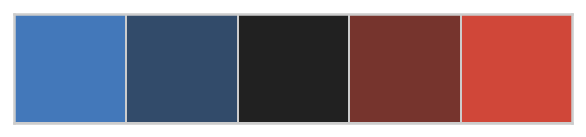

In [28]:
sns.palplot(sns.diverging_palette(250, 15, n=5, center="dark"))

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


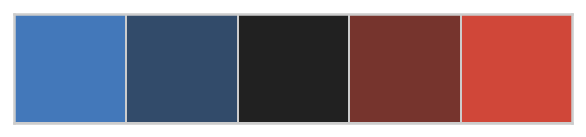

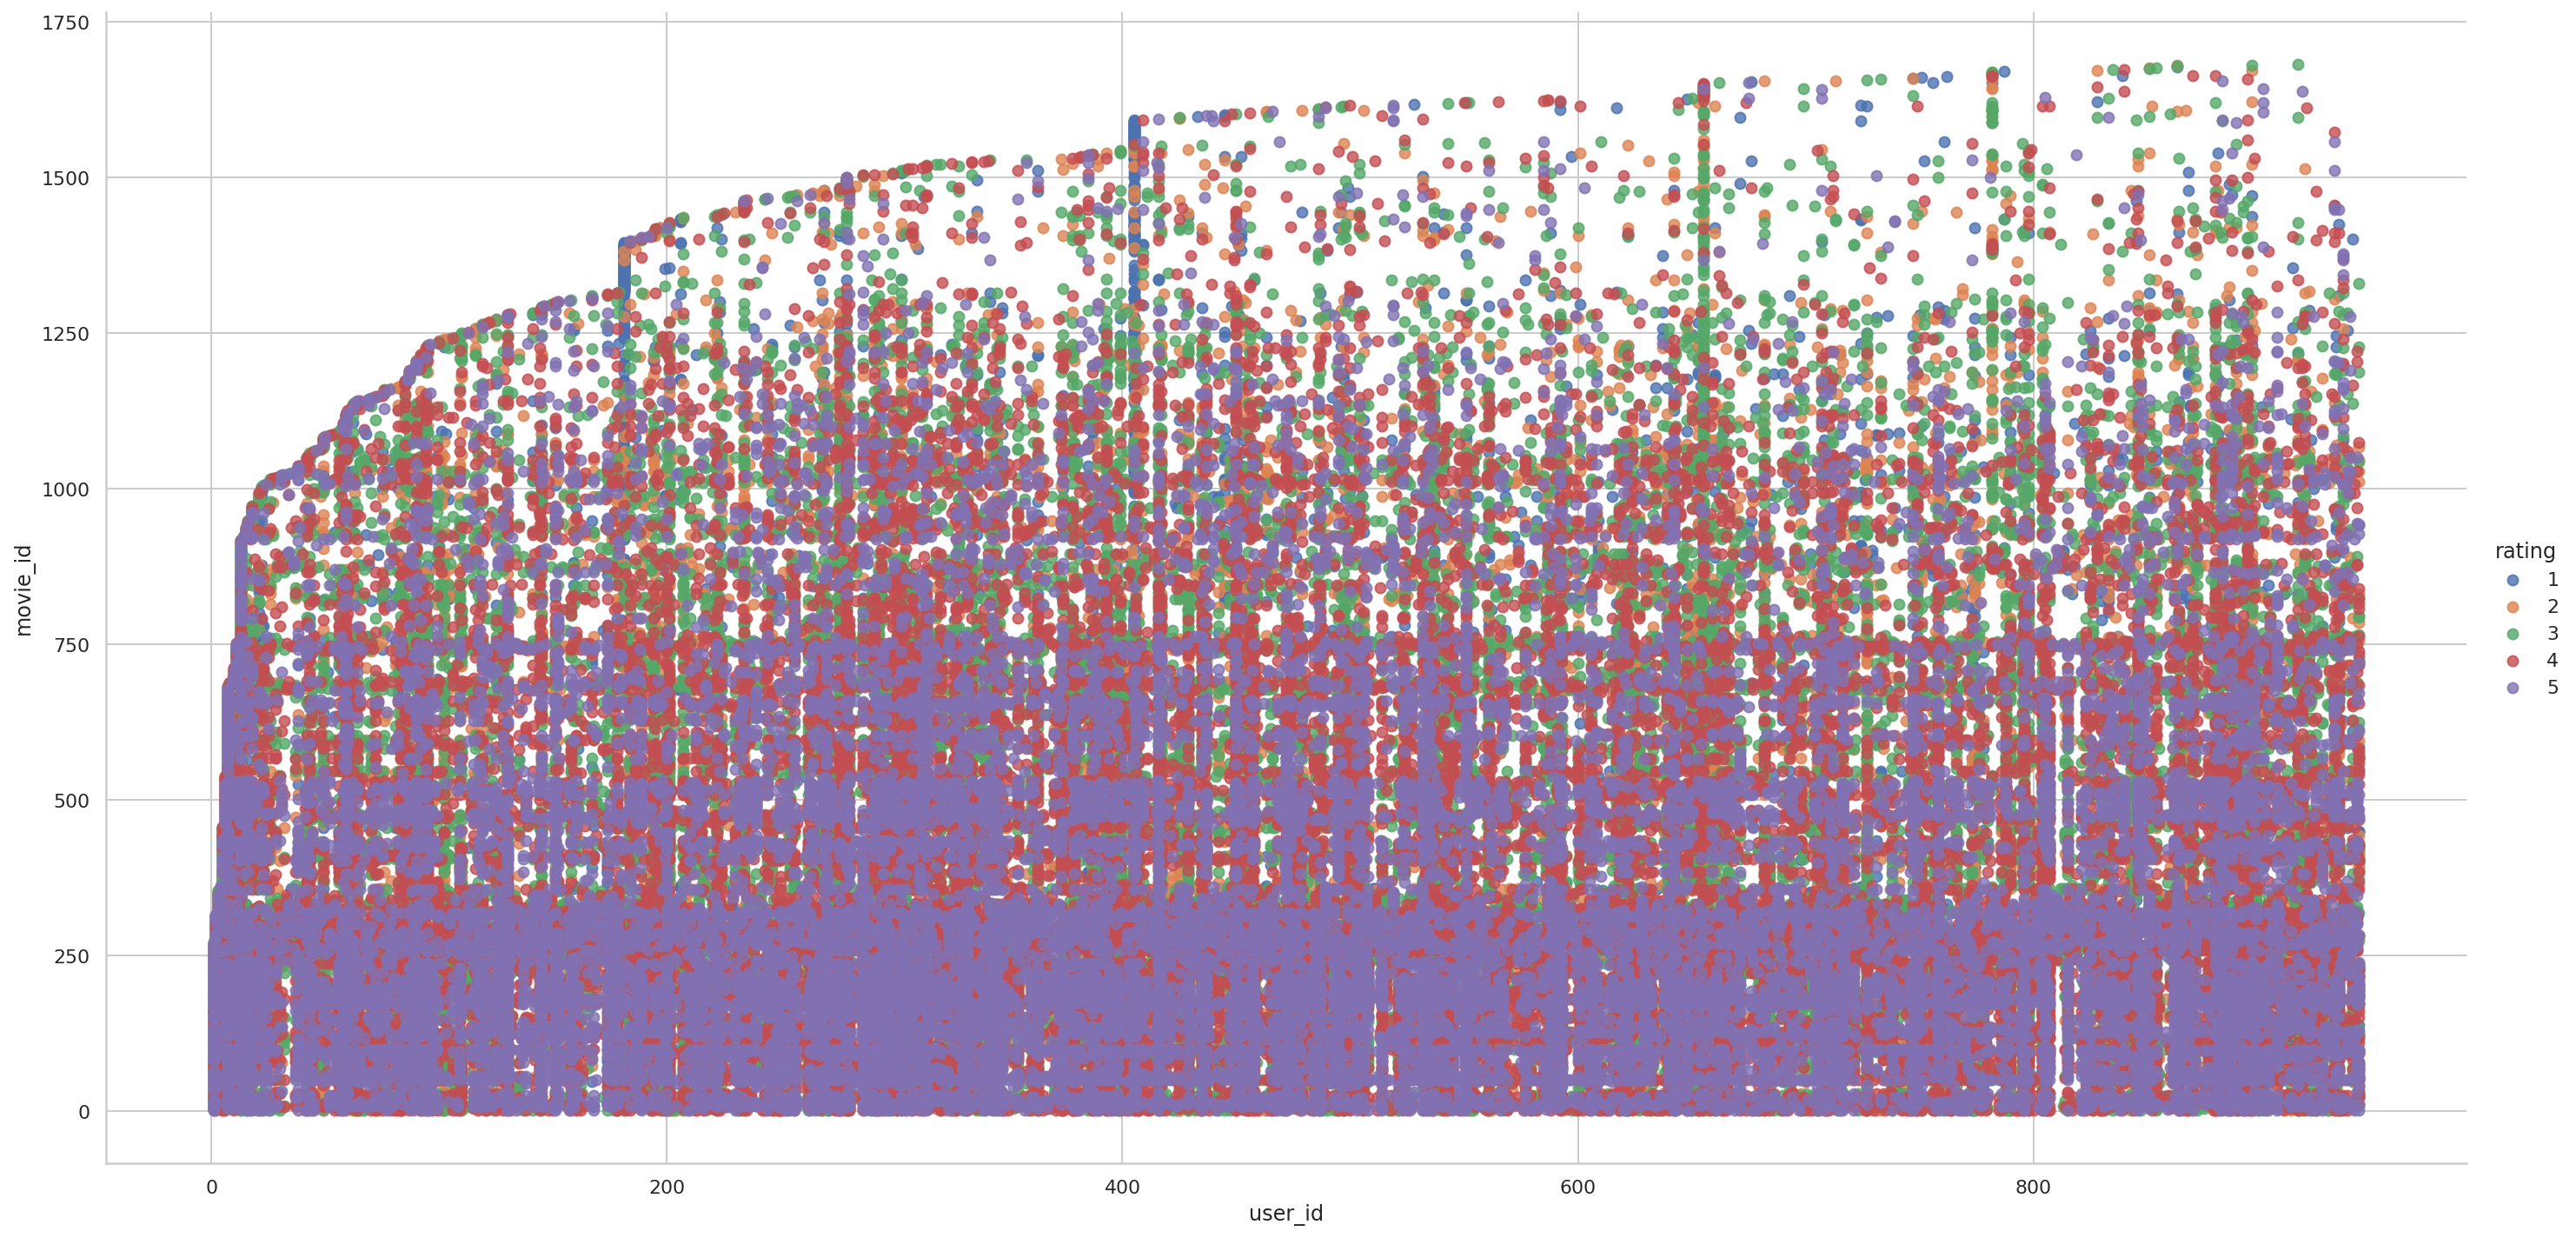

In [29]:
lm = (sns.lmplot(x='user_id', y='movie_id', hue='rating', 
                 data=ratings_df.toPandas(), 
                 fit_reg=False, size=10, aspect=2, 
                 palette=sns.palplot(sns.diverging_palette(250, 15, n=5, center="dark"))))
#axes = lm.axes
#axes[0,0].set_ylim(0,1682) # max movieId is 1682
#axes[0,0].set_xlim(0,943) # max userId is 943
#lm

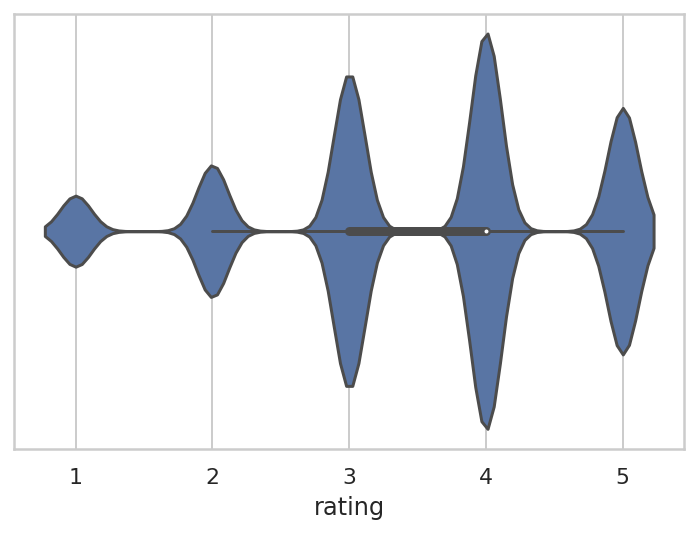

In [30]:
sns.violinplot(ratings_df.toPandas()['rating'])

In [31]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

In [32]:

spark.sql(strip_margin(
                    """SELECT *, 100 * nb_ratings/matrix_size AS percentage
                      |FROM (
                      |    SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
                      |    FROM (
                      |        SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movie_id)) AS nb_movies, COUNT(DISTINCT(user_id)) AS nb_users
                      |        FROM ratings
                      |    )
                      |)
                    """)).show(truncate=False)

+--------+---------+----------+-----------+-----------------+
|nb_users|nb_movies|nb_ratings|matrix_size|percentage       |
+--------+---------+----------+-----------+-----------------+
|943     |1682     |100000    |1586126    |6.304669364224532|
+--------+---------+----------+-----------+-----------------+



Less than 6% of the matrix is filled.

To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. Here's the general iterative process of machine learning:

In [33]:
train_df, test_df = ratings_df.randomSplit([0.8, 0.2], seed=rnd_seed)

In [34]:

# we will cache the data because we will be using this dataframes over and over again
train_df.cache()
test_df.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

DataFrame[user_id: smallint, movie_id: smallint, rating: tinyint]

In [35]:
# Build the recommendation model using ALS on the training data
als = ALS(rank=10, maxIter=10, regParam=0.01, userCol='user_id', itemCol='movie_id', ratingCol='rating', coldStartStrategy="drop", seed=rnd_seed)

In [36]:

model = als.fit(train_df)

In [37]:
# How many latent factors for users
model.userFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-0.5154238, -0.635073, 0.42631185, -0.5892158, -0.10010116, 0.47463632, 0.14913993, 0.865479, 0....|
| 20|[-0.8414512, -0.6655131, 0.33766606, 0.04450774, 0.61033505, 1.5781559, -1.2858609, 0.837861, -0....|
| 30|[-0.47698277, -0.53713083, 1.1571032, -0.2893211, -0.05059364, 0.6675711, 0.2659655, 1.0381728, 0...|
| 40|[-1.737807, -0.07611485, 0.50296944, 0.16324735, -0.006809239, -0.15724635, 1.0716392, 0.2902018,...|
| 50|[0.3683604, -0.23779987, -0.012957378, -2.7039075, 1.1672689, -1.3250238, 0.68998784, 0.49957392,...|
| 60|[-0.5984258, -0.6413872, 0.059357442, -0.9871669, 0.16097169, 0.67052156, 0.037831154, 0.68229365...|
| 70|[-0.42760336, -0.44033527, 0.674

In [38]:

# How many users
model.userFactors.count()

943

In [39]:

# How many latent factors for items
model.itemFactors.show(10, 100)

+---+----------------------------------------------------------------------------------------------------+
| id|                                                                                            features|
+---+----------------------------------------------------------------------------------------------------+
| 10|[-0.8756291, -0.65847933, -0.5521603, -0.60438776, 0.7755649, 2.1227396, 1.4992216, 0.6239599, 0....|
| 20|[-0.23789166, -0.63528275, 0.5592965, -0.07399931, -0.8020678, 2.358954, 0.7340622, 1.2279798, 0....|
| 30|[-0.039206743, -1.8941247, 0.016081449, -0.7033353, 0.4443122, 0.8281009, 0.8063842, 0.98583883, ...|
| 40|[-1.2019038, -0.88038003, 0.6607042, -0.98317194, 1.2364286, 1.5012138, 0.17337462, -0.12898533, ...|
| 50|[-0.8901977, -0.7250366, 0.5349887, -0.6831354, -0.061451666, 1.3100693, 0.4365186, 1.1906908, 1....|
| 60|[-0.65625054, -1.6098682, -1.1260493, -0.92026806, 0.52775913, 1.6686848, 1.3428246, 0.42227167, ...|
| 70|[-0.47900668, -1.1477107, 0.6641

In [40]:
# How many Movies
model.itemFactors.count()

1657

In [41]:
# How may Latent Factors?
model.rank

10

In [42]:
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", seed=rnd_seed)

In [43]:
paramGrid = (ParamGridBuilder()
             .addGrid(als.rank, [1, 5, 10])
             .addGrid(als.maxIter, [20])
             .addGrid(als.regParam, [0.05, 0.1, 0.5])
             .build())

In [44]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='rating', metricName='rmse')

In [45]:
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

In [46]:
cvModel = crossval.fit(train_df)

In [47]:
best_model = cvModel.bestModel

In [48]:
test_df.sample(fraction=0.01).limit(10).show(10)

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|     13|     347|     5|
|     13|     590|     2|
|    127|      62|     5|
|    200|     496|     5|
|    221|     461|     4|
|    276|     779|     2|
|    290|     172|     5|
|    308|     200|     5|
|    318|     476|     4|
|    326|     173|     5|
+-------+--------+------+



In [49]:
movie_rating_preds = cvModel.transform(test_df)

In [53]:
movie_rating_preds.show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    406|     148|     3| 2.5310247|
|     44|     148|     4| 2.9906058|
|    271|     148|     3| 2.6265996|
|    916|     148|     2| 2.3531117|
|    330|     148|     4| 4.2131395|
|    372|     148|     5| 4.0924883|
|    435|     148|     3| 2.8716314|
|    164|     148|     5|   4.22978|
|    620|     148|     3| 4.2059503|
|    430|     148|     2| 2.8899364|
|    347|     148|     3|  2.755346|
|    455|     148|     3|  2.929863|
|    486|     148|     2| 2.3265212|
|    677|     148|     4| 3.6317658|
|    733|     148|     3| 1.8281336|
|     49|     148|     1| 1.4229435|
|    244|     148|     2| 2.8890836|
|    532|     148|     5| 3.9845881|
|    706|     148|     4| 3.2262857|
|    181|     148|     2| 1.9106679|
+-------+--------+------+----------+
only showing top 20 rows



In [54]:
movie_rating_preds.filter("prediction < 1.0 or prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
|    330|     496|     5|   5.19831|
|    532|     496|     5| 5.0482445|
|    626|     243|     1| 0.7665726|
|     13|     858|     1| 0.8136143|
|    405|     858|     1| 0.6674398|
|     88|     898|     4|  5.229513|
|    206|     362|     1| 0.6046987|
|    181|     976|     1|0.83887136|
|    206|     683|     1|0.53580165|
|     86|    1175|     5| 5.1025133|
|    568|     988|     1|0.96179515|
|    803|     688|     1| 0.8933699|
|    688|     332|     5|   5.44669|
|    774|     743|     1| 0.7046602|
|    472|      12|     5| 5.0762134|
|    264|      12|     5| 5.0482388|
|    181|    1215|     1|0.71113455|
|    472|      22|     5| 5.0699134|
|    181|     995|     1|0.98678666|
|     38|     122|     1| 0.7367303|
+-------+--------+------+----------+
only showing top 20 rows



In [55]:

movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction", 
                                  F.when(col("prediction") > 5.0, 5.0)
                                  .when(col("prediction") < 1.0, 1.0)
                                  .otherwise(col("prediction")))
                     )

In [57]:
# recheck if there any any out of bound values
movie_rating_preds.filter("prediction < 1.0 and prediction > 5.0").show()

+-------+--------+------+----------+
|user_id|movie_id|rating|prediction|
+-------+--------+------+----------+
+-------+--------+------+----------+



In [58]:
movie_rating_preds.printSchema()

root
 |-- user_id: short (nullable = true)
 |-- movie_id: short (nullable = true)
 |-- rating: byte (nullable = true)
 |-- prediction: double (nullable = false)



In [59]:
movie_rating_preds = (movie_rating_preds
                      .withColumn("prediction_rounded", F.rint('prediction').cast(FloatType()))
                      .withColumn("rating", col('rating').cast(FloatType()))
                     )
movie_rating_preds.cache()

DataFrame[user_id: smallint, movie_id: smallint, rating: float, prediction: double, prediction_rounded: float]

In [60]:
movie_rating_preds.show(10)

+-------+--------+------+------------------+------------------+
|user_id|movie_id|rating|        prediction|prediction_rounded|
+-------+--------+------+------------------+------------------+
|    406|     148|   3.0| 2.531024694442749|               3.0|
|     44|     148|   4.0|2.9906058311462402|               3.0|
|    271|     148|   3.0|2.6265995502471924|               3.0|
|    916|     148|   2.0| 2.353111743927002|               2.0|
|    330|     148|   4.0| 4.213139533996582|               4.0|
|    372|     148|   5.0|4.0924882888793945|               4.0|
|    435|     148|   3.0| 2.871631383895874|               3.0|
|    164|     148|   5.0| 4.229780197143555|               4.0|
|    620|     148|   3.0|4.2059502601623535|               4.0|
|    430|     148|   2.0|2.8899364471435547|               3.0|
+-------+--------+------+------------------+------------------+
only showing top 10 rows



In [61]:
RMSE = evaluator.evaluate(movie_rating_preds)

In [62]:
print("Root Mean Squared Error = {0}".format(RMSE))

Root Mean Squared Error = 0.916703034436779


In [63]:
# RMSE with rating rounded column
RegressionEvaluator(predictionCol='prediction_rounded', labelCol='rating', metricName='rmse').evaluate(movie_rating_preds)

0.9608455554147094

In [64]:
from pyspark.mllib.evaluation import RankingMetrics, RegressionMetrics

In [65]:
perUserActual = (movie_rating_preds
                 .where(col("rating") > 2.5)
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))

In [66]:

perUserActual.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    148|[596, 238, 194, 5...|
|    463|[19, 880, 270, 15...|
|    833|[234, 205, 32, 24...|
|    496|[132, 206, 526, 1...|
|    897|[763, 742, 183, 2...|
|    243|[1148, 15, 458, 7...|
|    540|[9, 300, 343, 125...|
|    392|[197, 604, 321, 3...|
|    623|[186, 183, 659, 2...|
|    737|[12, 475, 258, 12...|
|    858|[9, 292, 307, 286...|
|     31|[306, 321, 611, 1...|
|    516|[212, 204, 357, 9...|
|    137|[1, 249, 300, 118...|
|    251|[520, 12, 742, 24...|
|    451|[321, 749, 304, 9...|
|     85|[204, 1039, 357, ...|
|    580|[222, 1, 121, 866...|
|    808|[748, 288, 750, 2...|
|     65|[15, 661, 356, 16...|
+-------+--------------------+
only showing top 20 rows



In [68]:
perUserPredictions = (movie_rating_preds.orderBy(["user_id", "prediction"], ascending=[True, False])
                 .groupBy("user_id")
                 .agg(F.collect_set("movie_id").alias("movies")))

perUserPredictions.show()

+-------+--------------------+
|user_id|              movies|
+-------+--------------------+
|    148|[596, 238, 50, 19...|
|    463|[1, 880, 270, 952...|
|    496|[132, 496, 206, 5...|
|    833|[234, 205, 32, 24...|
|    243|[1148, 15, 458, 7...|
|    392|[197, 538, 604, 3...|
|    540|[9, 300, 343, 125...|
|    623|[186, 183, 659, 8...|
|    737|[12, 475, 258, 12...|
|    858|[9, 292, 307, 286...|
|    897|[763, 204, 183, 7...|
|     31|[611, 306, 321, 1...|
|    516|[212, 204, 357, 9...|
|     85|[51, 204, 357, 10...|
|    137|[1, 249, 300, 118...|
|    251|[520, 12, 748, 74...|
|    451|[269, 880, 321, 7...|
|    580|[281, 748, 222, 1...|
|    808|[748, 288, 750, 2...|
|     65|[15, 661, 655, 16...|
+-------+--------------------+
only showing top 20 rows



In [69]:
perUserActualvPred = (perUserActual.join(perUserPredictions, ["user_id"]).rdd
                      .map(lambda row: (row[1], row[2][:15])))

In [73]:
ranks = RankingMetrics(perUserActualvPred)

In [74]:
ranks

In [71]:
ranks.meanAveragePrecision

0.8173071511884448

In [75]:
ranks.precisionAt(5)

0.8916309012875535

In [76]:
# top 3 movies recommended for each user
user_recs = best_model.recommendForAllUsers(3)

In [77]:
user_recs.show(truncate=False)

+-------+---------------------------------------------------------+
|user_id|recommendations                                          |
+-------+---------------------------------------------------------+
|471    |[[1427, 5.9470425], [791, 5.919014], [1260, 5.549179]]   |
|463    |[[1463, 4.6371], [1643, 4.2590446], [1449, 4.2556953]]   |
|833    |[[1368, 4.7556133], [390, 4.722366], [1022, 4.4996247]]  |
|496    |[[838, 5.5064783], [913, 4.9346976], [1368, 4.91701]]    |
|148    |[[1463, 5.7172427], [851, 5.4758215], [1643, 5.3623633]] |
|540    |[[1463, 5.166435], [1643, 5.140046], [1467, 5.000685]]   |
|392    |[[1463, 5.815464], [1643, 5.807621], [1449, 5.185445]]   |
|243    |[[1233, 5.128433], [1463, 4.7574363], [1449, 4.685838]]  |
|623    |[[1643, 5.45942], [1463, 5.3403373], [814, 4.937395]]    |
|737    |[[1405, 5.2955313], [838, 5.135575], [1536, 4.9274807]]  |
|897    |[[1467, 5.215372], [1450, 5.1999245], [1643, 5.1655335]] |
|858    |[[838, 5.095508], [1233, 4.6716685], [1

In [79]:

# python trick to display data types inside the dataframe
user_recs

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

In [81]:
user_recs_one = user_recs.where(user_recs.user_id == 1).cache()

In [82]:
user_recs_one.show(truncate=False)

+-------+------------------------------------------------------+
|user_id|recommendations                                       |
+-------+------------------------------------------------------+
|1      |[[1643, 5.47509], [1463, 5.354054], [1405, 5.0937867]]|
+-------+------------------------------------------------------+



In [83]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").collect()

[Row(user_id=1, movie_id=[1643, 1463, 1405], rating=[5.475090026855469, 5.354053974151611, 5.093786716461182])]

In [84]:
user_recs_one.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+------------------+--------------------+
|user_id|          movie_id|              rating|
+-------+------------------+--------------------+
|      1|[1643, 1463, 1405]|[5.47509, 5.35405...|
+-------+------------------+--------------------+



Reshape using a Sequence Id (Join Using monotonically_increasing_id()):

In order to join the recommended movies and recommended ratings we need to introduce an additional id column. In order to ensure that the values in the id column is increasing we use the monotonically_increasing_id() function. This function is guaranteed to produce increasing numbers but not guaranteed to produce sequential increasing numbers if there are more than 1 partition in the dataframe. So we also repartition the exploded dataframe into 1 partition.

In [85]:
only_movies = user_recs_one.select("user_id", F.explode(col("recommendations.movie_id")).alias("movie_id"))
only_movies = only_movies.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_movies = only_movies.select('id', 'user_id', 'movie_id')
only_movies.show()

+---+-------+--------+
| id|user_id|movie_id|
+---+-------+--------+
|  0|      1|    1643|
|  1|      1|    1463|
|  2|      1|    1405|
+---+-------+--------+



In [86]:
only_ratings = user_recs_one.select("user_id", F.explode(col("recommendations.rating")).alias("rating"))
only_ratings = only_ratings.repartition(1).withColumn('id', F.monotonically_increasing_id())
only_ratings = only_ratings.select('id', 'user_id', 'rating')
only_ratings.show()

+---+-------+---------+
| id|user_id|   rating|
+---+-------+---------+
|  0|      1|  5.47509|
|  1|      1| 5.354054|
|  2|      1|5.0937867|
+---+-------+---------+



In [87]:
only_movies.join(only_ratings.drop('user_id'), on='id', how='inner').drop('id').show()


+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      1|    1643|  5.47509|
|      1|    1463| 5.354054|
|      1|    1405|5.0937867|
+-------+--------+---------+



Reshape without using a Sequence Id:

We can do the same thing as above even without using a id column. All we need to do is to explode the struct column and then select the sub fields of the struct column.

In [88]:
only_movies

DataFrame[id: bigint, user_id: int, movie_id: int]

In [89]:
user_recs_one_record = user_recs_one.select("user_id", F.explode("recommendations").alias("reco"))
user_recs_one_record.show()

+-------+-----------------+
|user_id|             reco|
+-------+-----------------+
|      1|  [1643, 5.47509]|
|      1| [1463, 5.354054]|
|      1|[1405, 5.0937867]|
+-------+-----------------+



Although, the explode("recommendations") is now generated as "reco" we can still access subfields of that struct column. This information is hiddent inside the column metadata.

In [90]:
user_recs_one.unpersist()

DataFrame[user_id: int, recommendations: array<struct<movie_id:int,rating:float>>]

In [91]:
#ilter out the user we are interested from the set of all predictions:
user_recs.where(user_recs.user_id == 2).show(truncate=False)
#Create a subset user dataframe and invoke recommendForUserSubset on the model:
user_subset = ratings_df.where(ratings_df.user_id == 2)

user_subset.show()

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|2      |[[1463, 5.3513646], [1643, 5.3296065], [1449, 5.002738]]|
+-------+--------------------------------------------------------+

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      2|     237|     4|
|      2|     316|     5|
|      2|     100|     5|
|      2|     286|     4|
|      2|     274|     3|
|      2|      19|     3|
|      2|     294|     1|
|      2|     306|     4|
|      2|     308|     3|
|      2|     293|     4|
|      2|      25|     4|
|      2|     307|     3|
|      2|     275|     5|
|      2|     290|     3|
|      2|     298|     3|
|      2|     276|     4|
|      2|     283|     5|
|      2|     300|     4|
|      2|      14|     4|
|      2|     296|     3|
+-------+--------+------+
only showing top 20 rows



In [92]:
user_subset_recs = best_model.recommendForUserSubset(user_subset, 3)
user_subset_recs.show(truncate=False)

+-------+--------------------------------------------------------+
|user_id|recommendations                                         |
+-------+--------------------------------------------------------+
|2      |[[1463, 5.3513646], [1643, 5.3296065], [1449, 5.002738]]|
+-------+--------------------------------------------------------+



In [93]:
(user_subset_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|      2|    1463|5.3513646|
|      2|    1643|5.3296065|
|      2|    1449| 5.002738|
+-------+--------+---------+



In [94]:
# top 3 users recommended for each movie, for all movies.
movie_recs = best_model.recommendForAllItems(3)

In [95]:
movie_recs.show(truncate=False)

+--------+------------------------------------------------------+
|movie_id|recommendations                                       |
+--------+------------------------------------------------------+
|1580    |[[434, 1.3371906], [78, 1.1926658], [340, 1.1687455]] |
|471     |[[688, 5.0354137], [849, 4.912801], [507, 4.696154]]  |
|1591    |[[310, 5.4077654], [928, 5.340469], [68, 5.3393965]]  |
|1342    |[[34, 4.0799356], [511, 4.008059], [180, 3.899515]]   |
|463     |[[274, 4.722945], [414, 4.686792], [803, 4.6718783]]  |
|833     |[[127, 4.858107], [137, 4.4334693], [388, 4.3182592]] |
|496     |[[152, 5.3944817], [849, 5.3675847], [78, 5.3537226]] |
|148     |[[688, 4.961588], [849, 4.7944546], [507, 4.74158]]   |
|1088    |[[471, 4.4624352], [36, 4.3284483], [261, 4.115849]]  |
|1238    |[[261, 4.760172], [519, 4.4559426], [427, 4.4020233]] |
|540     |[[688, 3.7146938], [849, 3.7070675], [939, 3.5562086]]|
|1460    |[[732, 3.7984467], [810, 3.793293], [808, 3.702459]]  |
|392     |

In [96]:
#Filter out the movie we are interested from the set of all predictions:
movie_recs_one = movie_recs.where(movie_recs.movie_id == 36).cache()
movie_recs_one.show(truncate=False)

+--------+-----------------------------------------------------+
|movie_id|recommendations                                      |
+--------+-----------------------------------------------------+
|36      |[[688, 3.217798], [810, 3.1540718], [849, 3.1345158]]|
+--------+-----------------------------------------------------+



In [97]:
movie_recs_one.select("recommendations.user_id", "recommendations.rating").collect()

[Row(user_id=[688, 810, 849], rating=[3.2177979946136475, 3.154071807861328, 3.1345157623291016])]

In [99]:
movie_subset = ratings_df.where(ratings_df.movie_id == 36)
movie_subset.show()

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|    256|      36|     3|
|    201|      36|     1|
|    796|      36|     1|
|    477|      36|     4|
|    293|      36|     1|
|    393|      36|     3|
|    314|      36|     2|
|    405|      36|     2|
|      1|      36|     2|
|    846|      36|     2|
|    655|      36|     2|
|    184|      36|     3|
|    416|      36|     2|
+-------+--------+------+



In [100]:

movie_subset_recs = best_model.recommendForItemSubset(movie_subset, 3)
movie_subset_recs.select("movie_id", "recommendations.user_id", "recommendations.rating").show(truncate=False)



(movie_subset_recs
 .select("movie_id", F.explode("recommendations").alias("reco"))
 .select("movie_id", "reco.user_id", "reco.rating")).show()

+--------+---------------+--------------------------------+
|movie_id|user_id        |rating                          |
+--------+---------------+--------------------------------+
|36      |[688, 810, 849]|[3.217798, 3.1540718, 3.1345158]|
+--------+---------------+--------------------------------+

+--------+-------+---------+
|movie_id|user_id|   rating|
+--------+-------+---------+
|      36|    688| 3.217798|
|      36|    810|3.1540718|
|      36|    849|3.1345158|
+--------+-------+---------+



In [101]:
from pyspark.sql import Row
test_user_movie_df = spark.createDataFrame([Row(user_id=789, movie_id=123)], ['user_id', 'movie_id'])

In [102]:
test_user_movie_df.show()

+-------+--------+
|user_id|movie_id|
+-------+--------+
|    123|     789|
+-------+--------+



In [103]:
best_model.transform(test_user_movie_df).show()

+-------+--------+----------+
|user_id|movie_id|prediction|
+-------+--------+----------+
|    123|     789|  3.515702|
+-------+--------+----------+



In [104]:
test_user_df = spark.createDataFrame([Row(user_id=789)], ['user_id'])
test_user_df.show()

In [105]:
test_user_recs = best_model.recommendForUserSubset(test_user_df, 10).cache()
test_user_recs.select("user_id", "recommendations.movie_id", "recommendations.rating").show()

+-------+--------------------+--------------------+
|user_id|            movie_id|              rating|
+-------+--------------------+--------------------+
|    789|[1368, 1104, 1589...|[5.267265, 5.0798...|
+-------+--------------------+--------------------+



In [106]:
(test_user_recs
 .select("user_id", F.explode("recommendations").alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    789|    1368| 5.267265|
|    789|    1104|5.0798254|
|    789|    1589| 5.003438|
|    789|    1643|4.9879937|
|    789|    1022|4.9465437|
|    789|    1467|4.9391537|
|    789|     390|4.7934318|
|    789|    1388|4.7454667|
|    789|     838|4.7435737|
|    789|      56|4.6718698|
+-------+--------+---------+



In [107]:
movie_genres = (['unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 
                 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western'])

In [108]:
# An utility function to combine all active genres of the movie into an array
from numpy import ma
def combine_genres(genres):
    x = ma.masked_array(movie_genres, mask=(1 - np.array(genres)))
    return x[~x.mask].data.tolist()

In [113]:
combine_genres([0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0])

['adventure', 'comedy', 'documentary', 'fantasy', 'mystery', 'scifi', 'war']

In [114]:
udf_combine_genres = udf(lambda genres: combine_genres(genres), ArrayType(elementType=StringType()))

In [115]:
print('Recommended Top 10 Movies For User 789:')
(test_user_recs
 .select('user_id', F.explode(col("recommendations")).alias("reco"))
 .select("user_id", "reco.movie_id", "reco.rating")
 .join(movies_df, on=['movie_id'], how='inner')
 .withColumn('genres', udf_combine_genres(F.array('unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'musical', 'mystery', 'romance', 'scifi', 'thriller', 'war', 'western')))
 .select('user_id', 'movie_id', F.round('rating', 0).alias('rating'), 'title', 'genres')
 .orderBy(F.desc('rating'), 'movie_id')
).show(truncate=False)

Recommended Top 10 Movies For User 789:
+-------+--------+------+-------------------------------------+----------------------+
|user_id|movie_id|rating|title                                |genres                |
+-------+--------+------+-------------------------------------+----------------------+
|789    |56      |5.0   |Pulp Fiction (1994)                  |[crime, drama]        |
|789    |390     |5.0   |Fear of a Black Hat (1993)           |[comedy]              |
|789    |838     |5.0   |In the Line of Duty 2 (1987)         |[action]              |
|789    |1022    |5.0   |Fast, Cheap & Out of Control (1997)  |[documentary]         |
|789    |1104    |5.0   |C'est arriv� pr�s de chez vous (1992)|[comedy, crime, drama]|
|789    |1368    |5.0   |Mina Tannenbaum (1994)               |[drama]               |
|789    |1388    |5.0   |Gabbeh (1996)                        |[drama]               |
|789    |1467    |5.0   |Saint of Fort Washington, The (1993) |[drama]               |
|78

In [116]:
sqlContext.udf.register("sql_udf_combine_genres", combine_genres, ArrayType(elementType=StringType()))

<function __main__.combine_genres(genres)>

In [117]:
# Top 10 movies rated by user 789
print('Top 10 Rated Movies by User 789:')
spark.sql(strip_margin(
                    """SELECT r.user_id, r.movie_id, cast(r.rating as float), m.title, sql_udf_combine_genres(
                        array(unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, filmnoir, horror, musical, mystery, romance, scifi, thriller, war, western)
                        ) as genres FROM ratings r, movies m WHERE r.user_id = 789 AND r.movie_id = m.movie_id ORDER BY r.rating DESC, r.movie_id LIMIT 10
                    """)).show(truncate=False)

Top 10 Rated Movies by User 789:
+-------+--------+------+-------------------------------+----------------------------------------+
|user_id|movie_id|rating|title                          |genres                                  |
+-------+--------+------+-------------------------------+----------------------------------------+
|789    |9       |5.0   |Dead Man Walking (1995)        |[drama]                                 |
|789    |50      |5.0   |Star Wars (1977)               |[action, adventure, romance, scifi, war]|
|789    |100     |5.0   |Fargo (1996)                   |[crime, drama, thriller]                |
|789    |127     |5.0   |Godfather, The (1972)          |[action, crime, drama]                  |
|789    |129     |5.0   |Bound (1996)                   |[crime, drama, romance, thriller]       |
|789    |150     |5.0   |Swingers (1996)                |[comedy, drama]                         |
|789    |276     |5.0   |Leaving Las Vegas (1995)       |[drama, romance]   